# PyTorch - Fashion_Mnist

### 필요 라이브러리 불러오기

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [3]:
# GPU, CPU 설정

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cpu


### 데이터 준비

In [4]:
# 데이터 준비 1
transform = transforms.Compose([transforms.ToTensor()])

In [14]:
# 데이터 준비 2 (데이터셋 만들기)

train_dataset = datasets.FashionMNIST(root = 'data_files', 
                                      train=True, download=True, 
                                      transform=transform)
test_dataset = datasets.FashionMNIST(root = 'data_files', 
                                     train=False, download=True, 
                                     transform=transform)

# Train Dataset을 Train/Validation Datasest으로 분리
train_size = int(0.8 * len(train_dataset))  # 80% 훈련 데이터
val_size = len(train_dataset) - train_size  # 20% 검증 데이터

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [16]:
# 데이터 준비 3 (DataLoader)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                                batch_size = 32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = 32, shuffle=True)

torch.Size([32, 1, 28, 28]) torch.Size([32])


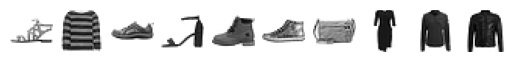

tensor([5, 2, 7, 5, 9, 7, 8, 3, 4, 4])

In [17]:
# 데이터 확인

for X, y in train_loader:
    print(X.shape, y.shape)
    break

for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.axis('off')
    plt.imshow(X[idx, :, :, :].reshape(28, 28), cmap='gray_r')
plt.show()
y[:10]

### 모델 만들기

In [32]:
# 모델 구조 설계

class FMnistCnn(nn.Module):
    def __init__(self):
        super(FMnistCnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 28 * 28 >(1st pooling)> 14 * 14 >(2nd pooling)> 7 * 7
        self.fc1 = nn.Linear(7*7*64, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 7*7*64)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
# 학습 도구 구성
model = FMnistCnn().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

print(model)

FMnistCnn(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [40]:
# 훈련 함수 정의

def train(model, train_loader, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if idx % 300 == 0:
            accuracy = 100 * correct / total
            print(f'Batch : {idx}, Loss : {loss.item()}, Accuracy : {accuracy}')
    
    # Epoch 결과 출력
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch Loss: {epoch_loss:.4f}, Epoch Accuracy: {epoch_accuracy:.2f}%')


In [42]:
# 학습 실행
for epoch in range(10):
    train(model, train_loader, optimizer)  # 훈련
    loss, accuracy = evaluate(model, test_loader, criterion, device)  # 평가
    print(f"Epoch : {epoch + 1}, Loss : {loss:.4f}, Accuracy : {accuracy:.2f}%")


Batch : 0, Loss : 0.34602177143096924, Accuracy : 84.375
Batch : 300, Loss : 0.3388572931289673, Accuracy : 87.76993355481727
Batch : 600, Loss : 0.4053109288215637, Accuracy : 87.88477537437603
Batch : 900, Loss : 0.28958576917648315, Accuracy : 87.86417869034406
Batch : 1200, Loss : 0.43008583784103394, Accuracy : 87.99958368026644
Epoch Loss: 0.3284, Epoch Accuracy: 87.96%
Epoch : 1, Loss : 0.3733, Accuracy : 86.49%
Batch : 0, Loss : 0.6246962547302246, Accuracy : 71.875
Batch : 300, Loss : 0.23009002208709717, Accuracy : 88.50705980066445
Batch : 600, Loss : 0.19815996289253235, Accuracy : 88.4619384359401
Batch : 900, Loss : 0.43094033002853394, Accuracy : 88.2838512763596
Batch : 1200, Loss : 0.5031000375747681, Accuracy : 88.26238551207327
Epoch Loss: 0.3171, Epoch Accuracy: 88.33%
Epoch : 2, Loss : 0.3350, Accuracy : 87.47%
Batch : 0, Loss : 0.2579491138458252, Accuracy : 93.75
Batch : 300, Loss : 0.15013335645198822, Accuracy : 88.86004983388705
Batch : 600, Loss : 0.425996541

In [43]:
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_total = 0
    correct_total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels).item()
            loss_total += loss
            _, predicted = torch.max(outputs, 1)
            correct_total += (predicted == labels).sum().item()
    
    loss_avg = loss_total / len(loader)
    accuracy = 100.0 * correct_total / len(loader.dataset)
    
    return loss_avg, accuracy


In [44]:
# 검증 데이터 평가 (Validation)
val_loss, val_accuracy = evaluate(model, validation_loader, criterion, device)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%')

Validation Loss: 0.33451463776826856, Validation Accuracy: 88.34166666666667%


In [45]:
#테스트 데이터 평가 (Test)
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

Test - Loss: 0.3478, Accuracy: 87.99%
